# Beaver Tutorial 6: ECG Arrhythmia Classification (Data Scientist)

Train an XGBoost model on the MIT-BIH dataset with privacy-preserving collaboration.

Run this alongside `06-ecg-do.ipynb` in a separate tab.


## Step 1: Setup


In [1]:
!uv pip install pandas numpy scikit-learn xgboost matplotlib seaborn keras torch pyarrow -q

In [2]:
# NOTE: Default Keras backend is PyTorch for notebook stability.
# If you switch to TensorFlow, import it before beaver on Apple Silicon to avoid a pyarrow/tf.data hang.
# References:
# - https://github.com/google/array_record/issues/179
# - https://github.com/tensorflow/tensorflow/issues/98563
# - https://github.com/huggingface/datasets/issues/7419
import os

os.environ.setdefault("KERAS_BACKEND", "torch")

import beaver
# Initialize Beaver session
bv = beaver.ctx()
session = bv.active_session()
session.reset(force=True)

print(f"You: {bv.user}")
print(f"Peer: {session.peer}")


🔄 Auto-load replies enabled for client2@sandbox.local (polling every 0.5s)
🟢 Active session loaded: dev_session_1767853045
   Peer: client1@sandbox.local
  Deleted: data/ (0 files)
✓ Session reset: 0 files deleted
You: client2@sandbox.local
Peer: client1@sandbox.local


In [3]:
# session.open()

## Step 2: Wait for ECG Data

**Run DO notebook Steps 1-3 first!**


In [4]:
ecg = session.wait_for_remote_var("ecg", timeout=600, trust_loader=True)
if ecg is None:
    raise RuntimeError("Timed out waiting for 'ecg'. Run DO notebook Steps 1-3 first.")
ecg

⏳ Waiting for 'ecg' from client1@sandbox.local...
📬 'ecg' is now available!


🌍 Twin: ecg (MOCK DATA - SAFE)
  🔒 Private    (not available) 💡 .request_private()
  🌍 Public    {'X': [[245.0, 244.0, -0.07580912858247757, -0.3709827065...    ← .value uses this
  Owner: client1@sandbox.local
  Live: ⚫ Disabled
  IDs: twin=47f2432a... private=36f96657... public=e614be87...

## Step 3: Define Remote XGBoost Training


In [5]:
@bv
def train_xgboost(data: dict) -> dict:
    """Train XGBoost and return model weights plus plots."""
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.manifold import TSNE
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from xgboost import XGBClassifier

    X = np.array(data["X"], dtype=np.float32)
    y = np.array(data["y"], dtype=np.int64)
    label_names = data.get("label_names")

    # Train/test split (avoid stratify if any class is too small)
    counts = np.bincount(y)
    stratify_y = y if counts.min() >= 2 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=stratify_y, random_state=42
    )

    model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        scale_pos_weight=1,
        random_state=42,
        eval_metric="mlogloss",
    )
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    test_accuracy = float((y_pred == y_test).mean() * 100.0)

    # Confusion matrix plot - use only labels present in data
    unique_labels = np.unique(np.concatenate([y_test, y_pred]))
    if label_names is not None:
        display_labels = [label_names[i] for i in unique_labels if i < len(label_names)]
    else:
        display_labels = unique_labels
    
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    fig_cm, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title("XGBoost Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # t-SNE plot (sample for speed)
    rng = np.random.default_rng(42)
    sample_size = min(3000, len(X))
    if sample_size < len(X):
        idx = rng.choice(len(X), size=sample_size, replace=False)
        X_sample = X[idx]
        y_sample = y[idx]
    else:
        X_sample = X
        y_sample = y

    X_scaled = StandardScaler().fit_transform(X_sample)
    tsne_kwargs = dict(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    try:
        tsne = TSNE(max_iter=1000, **tsne_kwargs)
    except TypeError:
        tsne = TSNE(n_iter=1000, **tsne_kwargs)
    X_tsne = tsne.fit_transform(X_scaled)

    plot_df = pd.DataFrame({
        "tsne1": X_tsne[:, 0],
        "tsne2": X_tsne[:, 1],
        "label": y_sample,
    })
    if label_names:
        plot_df["label_name"] = plot_df["label"].apply(lambda i: label_names[int(i)] if int(i) < len(label_names) else str(i))
        hue_col = "label_name"
    else:
        hue_col = "label"

    fig_tsne, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(
        data=plot_df,
        x="tsne1",
        y="tsne2",
        hue=hue_col,
        palette="Set1",
        alpha=0.7,
        ax=ax,
        legend="brief",
    )
    ax.set_title("t-SNE (2D) Projection of Heartbeat Classes")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    plt.tight_layout()
    plt.show()

    # Serialize model weights
    model_bytes = model.get_booster().save_raw()

    return {
        "test_accuracy": test_accuracy,
        "model_weights": bytes(model_bytes),
    }


## Step 4: Test on Mock Data


Mock accuracy: 90.00%
📊 Public figures (2):


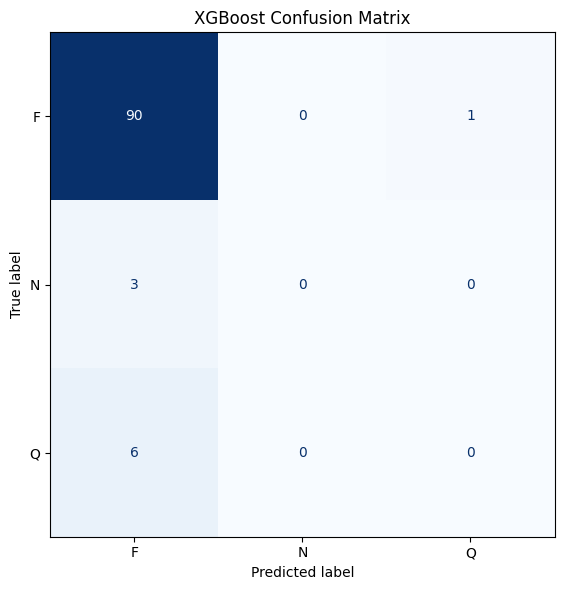

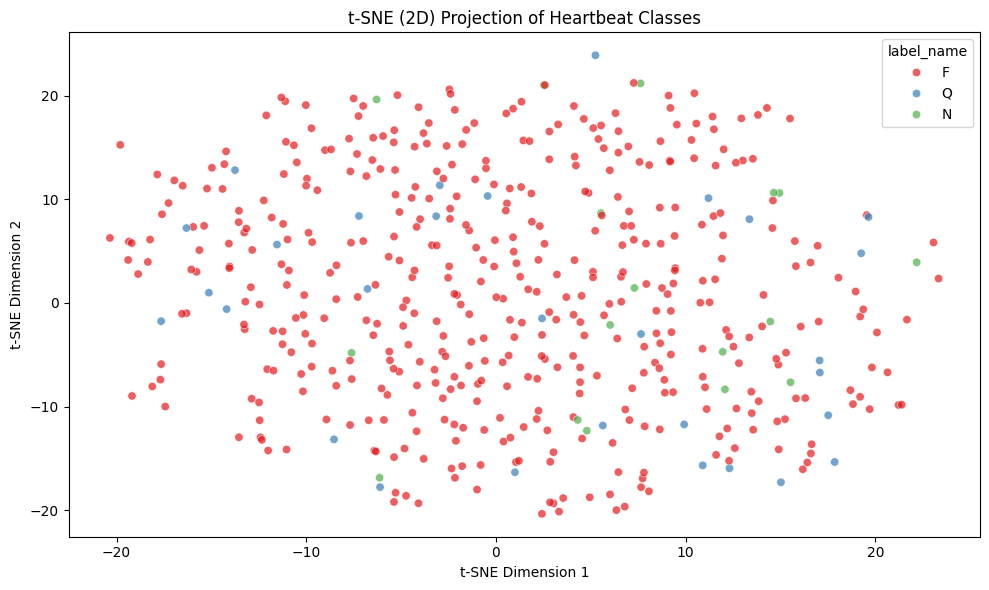

In [6]:
result = train_xgboost(ecg)
acc = result.public.get('test_accuracy') if result and result.public else None
if acc is None:
    print('Mock accuracy: N/A')
else:
    print(f"Mock accuracy: {acc:.2f}%")
result.show_figures("public")

## Step 5: Request Private Training


In [7]:
result_request = train_xgboost(ecg)
result_request.request_private()
print("Request sent! Run DO notebook Steps 4-7...")

📨 Sending computation request to client1@sandbox.local
   Function: train_xgboost
   Result: result_request
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/dev_session_1767853045/350b910e9ae94f71bc90a0a1e48113d4.beaver
💡 Result will auto-update when client1@sandbox.local approves
Request sent! Run DO notebook Steps 4-7...


## Step 6: Receive Results


⏳ Waiting for response to 'train_xgboost_result'...
   Looking for reply_to: a91e90e4c07d...
   Watching: ['/Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault', '/Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1767853045', '/Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault']
📬 Response received for 'train_xgboost_result'
   From: client1@sandbox.local
✅ 'train_xgboost_result' updated with result
Real accuracy: 96.00%
📊 Private figures (2):


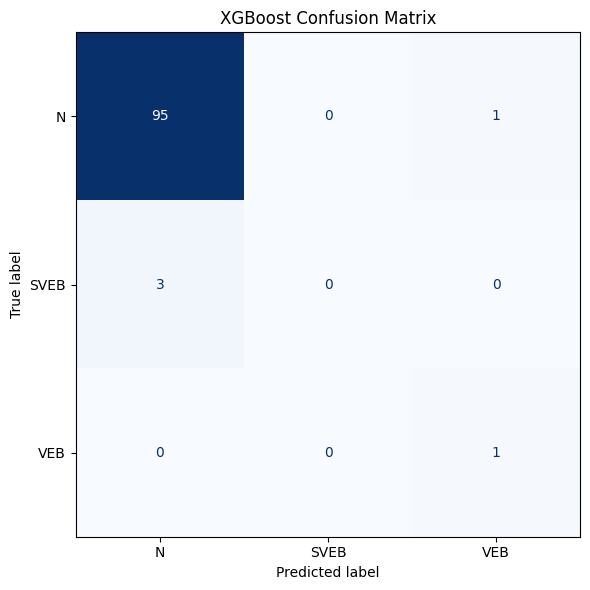

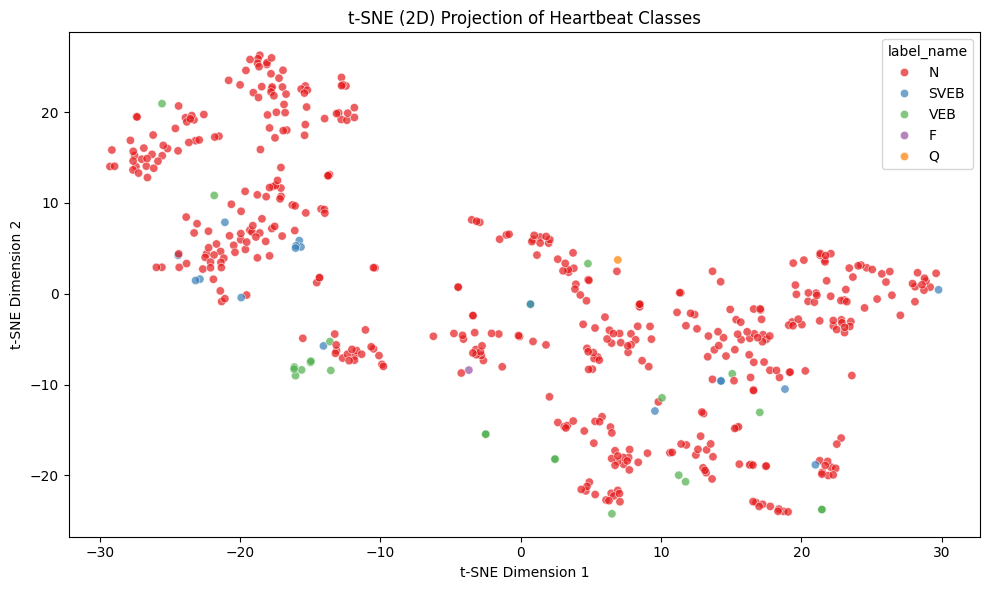

Model bytes: 988808


In [8]:
approved = bv.wait_for_response(result_request, timeout=1200)
acc = approved.private.get('test_accuracy')
if acc is None:
    print('Real accuracy: N/A')
else:
    print(f"Real accuracy: {acc:.2f}%")
approved.show_figures("private")
print(f"Model bytes: {len(approved.private.get('model_weights', b''))}")


## Step 7: Define Remote Keras MLP Training


In [9]:
@bv
def train_keras(data: dict) -> dict:
    """Train a Keras MLP and return model weights plus a confusion matrix."""
    import io
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    os.environ.setdefault("KERAS_BACKEND", "torch")
    import keras
    from keras import layers, utils

    X = np.array(data["X"], dtype=np.float32)
    y = np.array(data["y"], dtype=np.int64)
    label_names = data.get("label_names")

    X_scaled = StandardScaler().fit_transform(X)
    num_classes = len(np.unique(y))
    y_cat = utils.to_categorical(y, num_classes=num_classes)

    # Avoid stratify if any class is too small (e.g., mock subset)
    counts = np.bincount(y)
    stratify_y = y if counts.min() >= 2 else None

    X_train, X_test, y_train, y_test, y_train_lbl, y_test_lbl = train_test_split(
        X_scaled, y_cat, y, test_size=0.2, stratify=stratify_y, random_state=42
    )

    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(X_scaled.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=2)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)

    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    unique_labels = np.unique(np.concatenate([y_test_lbl, y_pred]))
    cm = confusion_matrix(y_test_lbl, y_pred, labels=unique_labels)
    if label_names is not None:
        display_labels = [
            label_names[label] if label < len(label_names) else str(label)
            for label in unique_labels
        ]
    else:
        display_labels = unique_labels

    try:
        fig_cm, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
        disp.plot(ax=ax, cmap="Blues", colorbar=False)
        ax.set_title("Keras MLP Confusion Matrix")
        plt.tight_layout()
        plt.show()
    except Exception as exc:
        print(f"⚠️ Confusion matrix plot failed: {exc}")

    # Serialize weights as compressed numpy bytes
    buf = io.BytesIO()
    weights = [np.array(w) for w in model.get_weights()]
    np.savez_compressed(buf, *weights)
    model_bytes = buf.getvalue()

    return {
        "test_accuracy": float(acc * 100.0),
        "model_weights": model_bytes,
    }


## Step 8: Test Keras on Mock Data

/Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client2@sandbox.local/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Mock accuracy (Keras): 91.00%
📊 Public figures (1):


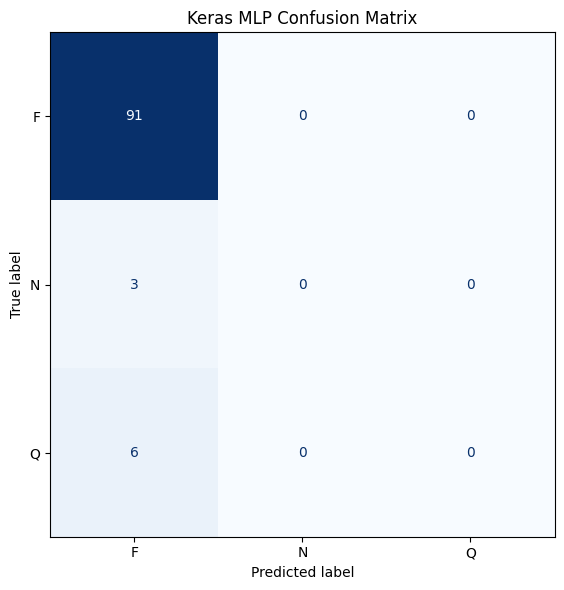

In [10]:
keras_result = train_keras(ecg)
acc = keras_result.public.get('test_accuracy') if keras_result and keras_result.public else None
if acc is None:
    print('Mock accuracy (Keras): N/A')
else:
    print(f"Mock accuracy (Keras): {acc:.2f}%")
keras_result.show_figures("public")

## Step 9: Request Private Keras Training


In [11]:
keras_request = train_keras(ecg)
keras_request.request_private()
print("Keras request sent! Run DO notebook Steps 8-11...")

📨 Sending computation request to client1@sandbox.local
   Function: train_keras
   Result: keras_request
✓ Sent to /Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/dev_session_1767853045/cd1570503fbe4f2d8637d869e89bd8e8.beaver
💡 Result will auto-update when client1@sandbox.local approves
Keras request sent! Run DO notebook Steps 8-11...


## Step 10: Receive Keras Results


⏳ Waiting for response to 'train_keras_result'...
   Looking for reply_to: 63e14348d340...
   Watching: ['/Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault', '/Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/dev_session_1767853045', '/Users/madhavajay/dev/biovault-beaver/workspace1/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault']
📬 Response received for 'train_keras_result'
   From: client1@sandbox.local
✅ 'train_keras_result' updated with result
Real accuracy (Keras): 96.00%
📊 Private figures (1):


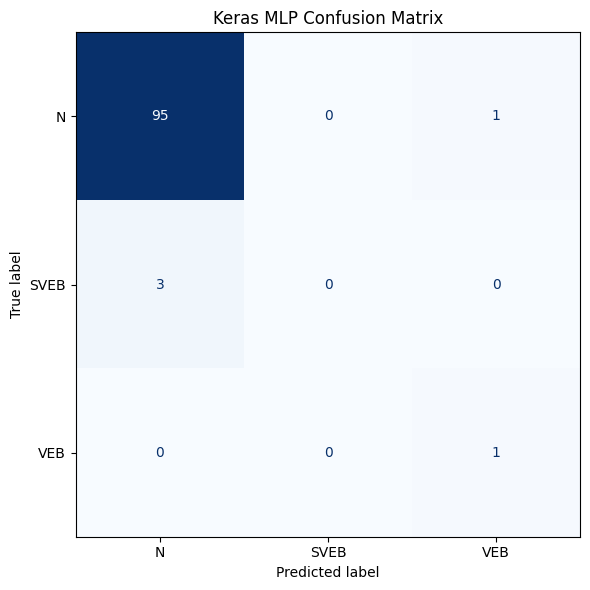

Model bytes: 43017


In [12]:
keras_approved = bv.wait_for_response(keras_request, timeout=1200)
acc = keras_approved.private.get('test_accuracy') if keras_approved and keras_approved.private else None
if acc is None:
    print('Real accuracy (Keras): N/A')
else:
    print(f"Real accuracy (Keras): {acc:.2f}%")
keras_approved.show_figures("private")
print(f"Model bytes: {len(keras_approved.private.get('model_weights', b''))}")


## Summary

- Trained XGBoost on mock data first
- Requested private XGBoost training on DO data
- Received model weights and plots (t-SNE + confusion matrix)
- Trained a Keras MLP and received model weights + confusion matrix

